In [1]:
# P.172 リスト5.1: 4,5,6,7/smiles_vae.py

import torch
from torch.nn.modules.module import DeviceLikeType
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm, notebook
from smiles_vae import SmilesVAE


def trainer(
    model: SmilesVAE,
    train_tensor: torch.Tensor,
    val_tensor: torch.Tensor,
    n_epoch: int = 10,
    lr: float = 1e-3,
    batch_size: int = 256,
    beta_schedule: list[float] = [0, 0, 0, 0, 0, 0.2, 0.4, 0.6, 0.8, 1.0],
    print_freq: int = 100,
    device: DeviceLikeType = "cpu",
) -> tuple[list[tuple[int, float]], list[tuple[int, float]], list[tuple[int, float]]]:
    """VAE の学習を行う関数

    Args:
        model (SmilesVAE): 学習する VAE モデル
        train_tensor (torch.Tensor): 訓練データの整数系列（サンプルサイズ * 最大系列長）
        val_tensor (torch.Tensor): 検証データの整数系列（サンプルサイズ * 最大系列長）
        n_epoch (int, optional): エポック数. Defaults to 10.
        lr (float, optional): 学習率. Defaults to 1e-3.
        batch_size (int, optional): ミニバッチを用いた確率的勾配降下法のバッチサイズ. Defaults to 256.
        beta_schedule (list[float], optional): KL 項の重みのスケジュール.
            Defaults to [0, 0, 0, 0, 0, 0.2, 0.4, 0.6, 0.8, 1.0].
        print_freq (int, optional): 途中経過を表示する頻度. Defaults to 100.
        device (DeviceLikeType, optional): 学習デバイス. Defaults to "cpu".

    Returns:
        tuple[list[tuple[int, float]], list[tuple[int, float]], list[tuple[int, float]]]:
            訓練データの損失関数の値、検証データの損失関数の値、検証データの再構成成功率
    """
    model.train()
    print(f"Using device: {device}")
    model.to(device)
    # 最適化手法のインスタンスを作成（モデルパラメタの最適化に確率的勾配降下法 (SGD) を用いる）
    # ここでは、確率的勾配降下法の中で Adaptive Moment Estimation を用いる
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # シャッフルありでバッチモードで訓練データの DataLoader を作成
    train_dataset = TensorDataset(torch.flip(train_tensor, dims=[1]), train_tensor)
    train_data_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )
    # シャッフルありでバッチモードで検証データの DataLoader を作成
    val_dataset = TensorDataset(torch.flip(val_tensor, dims=[1]), val_tensor)
    val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    # 訓練データの損失関数の値のリスト
    train_loss_list = []
    # 検証データの損失関数の値のリスト
    val_loss_list = []
    # 検証データの再構成成功率のリスト
    val_reconstruct_rate_list = []

    running_loss = 0
    running_sample_size = 0
    each_batch_idx = 0
    for each_epoch in notebook.tqdm(range(n_epoch)):
        try:
            model.beta = beta_schedule[each_epoch]
        except:
            pass
        tqdm.write(" beta = {}".format(model.beta))
        for each_train_batch in notebook.tqdm(train_data_loader, leave=False):
            # バッチごとに学習
            model.train()
            # 損失関数の計算
            each_loss = model.loss(
                each_train_batch[0].to(device), each_train_batch[1].to(device)
            )
            # 表示・作図用に記録
            running_loss += each_loss.item()
            running_sample_size += len(each_train_batch[0])
            # backward() 実行の度に optimizer に勾配が累積されるため、勾配を 0 にリセット
            optimizer.zero_grad()
            # パラメータに関する損失の勾配を計算
            each_loss.backward()
            # 蓄積した勾配を元にパラメタを更新
            optimizer.step()
            if (each_batch_idx + 1) % print_freq == 0:
                # print_freq の頻度で表示・作図用に記録
                train_loss_list.append(
                    (each_batch_idx + 1, running_loss / running_sample_size)
                )
                tqdm.write(
                    "#epoch: {}\t#update: {},\tper-example train loss:\t{}".format(
                        each_epoch,
                        each_batch_idx + 1,
                        running_loss / running_sample_size,
                    )
                )
            running_loss = 0
            running_sample_size = 0
            each_batch_idx += 1

        val_loss = 0
        each_val_success_list: list[bool] = []
        with torch.no_grad():
            # バッチごとに検証データの損失関数の値を計算（ここでは勾配の計算をしない）
            for each_val_batch in val_data_loader:
                # 損失関数の計算
                val_loss += model.loss(
                    each_val_batch[0].to(device), each_val_batch[1].to(device)
                ).item()
                each_val_success_list.extend(
                    model.reconstruct(each_val_batch[0].to(device), verbose=False)
                )
        val_loss_list.append((each_batch_idx + 1, val_loss / len(val_dataset)))
        val_reconstruct_rate_list.append(
            (
                each_batch_idx + 1,
                sum(each_val_success_list) / len(each_val_success_list),
            )
        )
        tqdm.write(
            "#update: {},\tper-example val loss:\t{}".format(
                each_batch_idx + 1, val_loss / len(val_dataset)
            )
        )
        tqdm.write(
            " * reconstruction success rate: {}".format(
                val_reconstruct_rate_list[-1][1]
            )
        )

    return train_loss_list, val_loss_list, val_reconstruct_rate_list

Using device: mps


  0%|          | 0/10 [00:00<?, ?it/s]

 beta = 0.1


  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 0	#update: 100,	per-example train loss:	0.378814160823822
#epoch: 0	#update: 200,	per-example train loss:	0.32586580514907837
#epoch: 0	#update: 300,	per-example train loss:	0.2892003655433655
#epoch: 0	#update: 400,	per-example train loss:	0.2569102644920349
#epoch: 0	#update: 500,	per-example train loss:	0.2396606057882309
#epoch: 0	#update: 600,	per-example train loss:	0.2276463359594345
#epoch: 0	#update: 700,	per-example train loss:	0.21341674029827118
#epoch: 0	#update: 800,	per-example train loss:	0.21753130853176117
#epoch: 0	#update: 900,	per-example train loss:	0.20941728353500366
#epoch: 0	#update: 1000,	per-example train loss:	0.1956787407398224
#epoch: 0	#update: 1100,	per-example train loss:	0.19360403716564178
#epoch: 0	#update: 1200,	per-example train loss:	0.18764284253120422
#epoch: 0	#update: 1300,	per-example train loss:	0.18358220160007477
#epoch: 0	#update: 1400,	per-example train loss:	0.1831236481666565
#epoch: 0	#update: 1500,	per-example train loss:	0.

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 1	#update: 5000,	per-example train loss:	0.11734413355588913
#epoch: 1	#update: 5100,	per-example train loss:	0.1152665764093399
#epoch: 1	#update: 5200,	per-example train loss:	0.120676688849926
#epoch: 1	#update: 5300,	per-example train loss:	0.11592740565538406
#epoch: 1	#update: 5400,	per-example train loss:	0.11678990721702576
#epoch: 1	#update: 5500,	per-example train loss:	0.11715636402368546
#epoch: 1	#update: 5600,	per-example train loss:	0.11254669725894928
#epoch: 1	#update: 5700,	per-example train loss:	0.10684523731470108
#epoch: 1	#update: 5800,	per-example train loss:	0.12113732844591141
#epoch: 1	#update: 5900,	per-example train loss:	0.10955529659986496
#epoch: 1	#update: 6000,	per-example train loss:	0.11404939740896225
#epoch: 1	#update: 6100,	per-example train loss:	0.10741326212882996
#epoch: 1	#update: 6200,	per-example train loss:	0.11263272911310196
#epoch: 1	#update: 6300,	per-example train loss:	0.11248122155666351
#epoch: 1	#update: 6400,	per-example 

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 2	#update: 10000,	per-example train loss:	0.09016166627407074
#epoch: 2	#update: 10100,	per-example train loss:	0.09281287342309952
#epoch: 2	#update: 10200,	per-example train loss:	0.09284187853336334
#epoch: 2	#update: 10300,	per-example train loss:	0.09646760672330856
#epoch: 2	#update: 10400,	per-example train loss:	0.09446505457162857
#epoch: 2	#update: 10500,	per-example train loss:	0.09453918784856796
#epoch: 2	#update: 10600,	per-example train loss:	0.09632459282875061
#epoch: 2	#update: 10700,	per-example train loss:	0.09731489419937134
#epoch: 2	#update: 10800,	per-example train loss:	0.09820857644081116
#epoch: 2	#update: 10900,	per-example train loss:	0.09030644595623016
#epoch: 2	#update: 11000,	per-example train loss:	0.08934959769248962
#epoch: 2	#update: 11100,	per-example train loss:	0.09471334517002106
#epoch: 2	#update: 11200,	per-example train loss:	0.09125541895627975
#epoch: 2	#update: 11300,	per-example train loss:	0.0956004336476326
#epoch: 2	#update: 11

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 3	#update: 15000,	per-example train loss:	0.08473549038171768
#epoch: 3	#update: 15100,	per-example train loss:	0.08240227401256561
#epoch: 3	#update: 15200,	per-example train loss:	0.08124203234910965
#epoch: 3	#update: 15300,	per-example train loss:	0.07793062925338745
#epoch: 3	#update: 15400,	per-example train loss:	0.08223018795251846
#epoch: 3	#update: 15500,	per-example train loss:	0.08582259714603424
#epoch: 3	#update: 15600,	per-example train loss:	0.08537966012954712
#epoch: 3	#update: 15700,	per-example train loss:	0.0800776556134224
#epoch: 3	#update: 15800,	per-example train loss:	0.08220120519399643
#epoch: 3	#update: 15900,	per-example train loss:	0.08409719914197922
#epoch: 3	#update: 16000,	per-example train loss:	0.07899142801761627
#epoch: 3	#update: 16100,	per-example train loss:	0.07901415973901749
#epoch: 3	#update: 16200,	per-example train loss:	0.07642941176891327
#epoch: 3	#update: 16300,	per-example train loss:	0.07912644743919373
#epoch: 3	#update: 16

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 4	#update: 19900,	per-example train loss:	0.07348914444446564
#epoch: 4	#update: 20000,	per-example train loss:	0.07985079288482666
#epoch: 4	#update: 20100,	per-example train loss:	0.07601699978113174
#epoch: 4	#update: 20200,	per-example train loss:	0.07615955173969269
#epoch: 4	#update: 20300,	per-example train loss:	0.07620511204004288
#epoch: 4	#update: 20400,	per-example train loss:	0.07626137137413025
#epoch: 4	#update: 20500,	per-example train loss:	0.08276818692684174
#epoch: 4	#update: 20600,	per-example train loss:	0.076459139585495
#epoch: 4	#update: 20700,	per-example train loss:	0.07872148603200912
#epoch: 4	#update: 20800,	per-example train loss:	0.07875499129295349
#epoch: 4	#update: 20900,	per-example train loss:	0.07155933976173401
#epoch: 4	#update: 21000,	per-example train loss:	0.07286987453699112
#epoch: 4	#update: 21100,	per-example train loss:	0.07472898066043854
#epoch: 4	#update: 21200,	per-example train loss:	0.07585696876049042
#epoch: 4	#update: 213

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 5	#update: 24900,	per-example train loss:	0.06456408649682999
#epoch: 5	#update: 25000,	per-example train loss:	0.07706333696842194
#epoch: 5	#update: 25100,	per-example train loss:	0.06871280074119568
#epoch: 5	#update: 25200,	per-example train loss:	0.0735415369272232
#epoch: 5	#update: 25300,	per-example train loss:	0.0713212788105011
#epoch: 5	#update: 25400,	per-example train loss:	0.07743245363235474
#epoch: 5	#update: 25500,	per-example train loss:	0.0728437528014183
#epoch: 5	#update: 25600,	per-example train loss:	0.06989870220422745
#epoch: 5	#update: 25700,	per-example train loss:	0.07240884006023407
#epoch: 5	#update: 25800,	per-example train loss:	0.0668003186583519
#epoch: 5	#update: 25900,	per-example train loss:	0.07167409360408783
#epoch: 5	#update: 26000,	per-example train loss:	0.06874006241559982
#epoch: 5	#update: 26100,	per-example train loss:	0.06883694976568222
#epoch: 5	#update: 26200,	per-example train loss:	0.07151325792074203
#epoch: 5	#update: 26300

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 6	#update: 29900,	per-example train loss:	0.06361642479896545
#epoch: 6	#update: 30000,	per-example train loss:	0.06936769932508469
#epoch: 6	#update: 30100,	per-example train loss:	0.0660654827952385
#epoch: 6	#update: 30200,	per-example train loss:	0.06600189208984375
#epoch: 6	#update: 30300,	per-example train loss:	0.06182317063212395
#epoch: 6	#update: 30400,	per-example train loss:	0.06374242156744003
#epoch: 6	#update: 30500,	per-example train loss:	0.06860210746526718
#epoch: 6	#update: 30600,	per-example train loss:	0.06366676837205887
#epoch: 6	#update: 30700,	per-example train loss:	0.0671825185418129
#epoch: 6	#update: 30800,	per-example train loss:	0.07068575918674469
#epoch: 6	#update: 30900,	per-example train loss:	0.0695214718580246
#epoch: 6	#update: 31000,	per-example train loss:	0.07076350599527359
#epoch: 6	#update: 31100,	per-example train loss:	0.06951326131820679
#epoch: 6	#update: 31200,	per-example train loss:	0.06611648947000504
#epoch: 6	#update: 3130

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 7	#update: 34900,	per-example train loss:	0.06415459513664246
#epoch: 7	#update: 35000,	per-example train loss:	0.07094400376081467
#epoch: 7	#update: 35100,	per-example train loss:	0.06076272204518318
#epoch: 7	#update: 35200,	per-example train loss:	0.06616127490997314
#epoch: 7	#update: 35300,	per-example train loss:	0.0600411593914032
#epoch: 7	#update: 35400,	per-example train loss:	0.061217304319143295
#epoch: 7	#update: 35500,	per-example train loss:	0.061054714024066925
#epoch: 7	#update: 35600,	per-example train loss:	0.06442234665155411
#epoch: 7	#update: 35700,	per-example train loss:	0.06388457119464874
#epoch: 7	#update: 35800,	per-example train loss:	0.05901298671960831
#epoch: 7	#update: 35900,	per-example train loss:	0.061885032802820206
#epoch: 7	#update: 36000,	per-example train loss:	0.0660683661699295
#epoch: 7	#update: 36100,	per-example train loss:	0.06535449624061584
#epoch: 7	#update: 36200,	per-example train loss:	0.0618409663438797
#epoch: 7	#update: 3

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 8	#update: 39800,	per-example train loss:	0.06668094545602798
#epoch: 8	#update: 39900,	per-example train loss:	0.06306947022676468
#epoch: 8	#update: 40000,	per-example train loss:	0.05931630730628967
#epoch: 8	#update: 40100,	per-example train loss:	0.060495827347040176
#epoch: 8	#update: 40200,	per-example train loss:	0.0657067596912384
#epoch: 8	#update: 40300,	per-example train loss:	0.06274575740098953
#epoch: 8	#update: 40400,	per-example train loss:	0.06083974242210388
#epoch: 8	#update: 40500,	per-example train loss:	0.055643483996391296
#epoch: 8	#update: 40600,	per-example train loss:	0.06088649109005928
#epoch: 8	#update: 40700,	per-example train loss:	0.06509280204772949
#epoch: 8	#update: 40800,	per-example train loss:	0.06378865242004395
#epoch: 8	#update: 40900,	per-example train loss:	0.06254174560308456
#epoch: 8	#update: 41000,	per-example train loss:	0.05823284387588501
#epoch: 8	#update: 41100,	per-example train loss:	0.05893879383802414
#epoch: 8	#update: 

  0%|          | 0/4973 [00:00<?, ?it/s]

#epoch: 9	#update: 44800,	per-example train loss:	0.05994207039475441
#epoch: 9	#update: 44900,	per-example train loss:	0.06344179064035416
#epoch: 9	#update: 45000,	per-example train loss:	0.06207843869924545
#epoch: 9	#update: 45100,	per-example train loss:	0.06056562066078186
#epoch: 9	#update: 45200,	per-example train loss:	0.05921197310090065
#epoch: 9	#update: 45300,	per-example train loss:	0.059435322880744934
#epoch: 9	#update: 45400,	per-example train loss:	0.06380770355463028
#epoch: 9	#update: 45500,	per-example train loss:	0.0577719584107399
#epoch: 9	#update: 45600,	per-example train loss:	0.054179608821868896
#epoch: 9	#update: 45700,	per-example train loss:	0.05796697363257408
#epoch: 9	#update: 45800,	per-example train loss:	0.059700287878513336
#epoch: 9	#update: 45900,	per-example train loss:	0.05581117793917656
#epoch: 9	#update: 46000,	per-example train loss:	0.060657985508441925
#epoch: 9	#update: 46100,	per-example train loss:	0.06040240824222565
#epoch: 9	#update

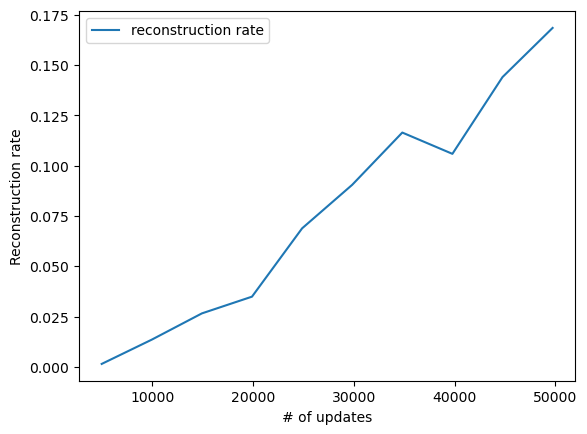

In [2]:
# P.178 リスト5.2: 4,5,6,7/smiles_vae_main.py

import matplotlib.pyplot as plt
import pickle
from smiles_vocab import SmilesVocabulary
from smiles_vae import SmilesVAE
from rdkit import Chem
from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


def valid_ratio(smiles_list: list[str]) -> float:
    """SMILES 文字列のリストから正しい SMILES 文字列の割合を計算

    Args:
        smiles_list (list[str]): SMILES 文字列のリスト

    Returns:
        float: 正しい SMILES 文字列の割合
    """
    n_success = 0
    for each_smiles in smiles_list:
        try:
            Chem.MolToSmiles(Chem.MolFromSmiles(each_smiles))
            n_success += 1
        except:
            pass
    return n_success / len(smiles_list)


if __name__ == "__main__":
    smiles_vocab = SmilesVocabulary()
    # 訓練データと検証データの整数系列を作成
    train_tensor = smiles_vocab.batch_update_from_file("train.smi")  # 1273104 * 102
    val_tensor = smiles_vocab.batch_update_from_file("val.smi")  # 79568 * 102
    max_len = val_tensor.shape[1]
    # VAE モデルのインスタンスを作成
    vae = SmilesVAE(
        smiles_vocab,
        latent_dim=64,
        emb_dim=256,
        encoder_params={
            "hidden_size": 512,
            "num_layers": 1,
            "bidirectional": False,
            "dropout": 0.0,
        },
        decoder_params={"hidden_size": 512, "num_layers": 1, "dropout": 0.0},
        encoder2out_params={"out_dim_list": [256]},
        max_len=max_len,
    )
    # 学習
    train_loss_list, val_loss_list, val_reconstruct_rate_list = trainer(
        vae,
        train_tensor,
        val_tensor,
        lr=1e-4,
        n_epoch=10,
        batch_size=256,
        beta_schedule=[0.1],
        print_freq=100,
        device=torch.device("mps") if torch.backends.mps.is_available() else "cpu",
    )
    # 学習中の訓練・検証用データセットにおける損失の値の推移をプロット
    plt.plot(*list(zip(*train_loss_list)), label="train loss")
    plt.plot(*list(zip(*val_loss_list)), label="validation loss", marker="*")
    plt.legend()
    plt.xlabel("# of updates")
    plt.ylabel("Loss function")
    plt.savefig("smiles_vae_learning_curve.pdf")
    # plt.clf()
    # 学習中の検証用データセットにおける再構成成功率の値の推移をプロット
    plt.plot(*list(zip(*val_reconstruct_rate_list)), label="reconstruction rate")
    plt.legend()
    plt.xlabel("# of updates")
    plt.ylabel("Reconstruction rate")
    plt.savefig("reconstruction_rate_curve.pdf")
    
    # 1000 個の新規 SMILES 文字列を生成
    smiles_list = vae.generate(sample_size=1000, deterministic=True)
    print("success rate: {}".format(valid_ratio(smiles_list)))
    # 学習済みモデルのパラメータをファイルに保存
    torch.save(vae.state_dict(), "vae.pt")
    # 生成した SMILES 文字列をファイルに保存
    with open("vae_smiles.pkl", "wb") as f:
        pickle.dump(smiles_list, f)

# 699m 27.3s

In [3]:
import pickle

pickle.dump(smiles_vocab, open("5_smiles_vocab.pkl", "wb"))
pickle.dump(train_tensor, open("5_train_tensor.pkl", "wb"))
pickle.dump(val_tensor, open("5_val_tensor.pkl", "wb"))
pickle.dump(vae, open("5_vae.pkl", "wb"))
pickle.dump(train_loss_list, open("5_train_loss_list.pkl", "wb"))
pickle.dump(val_loss_list, open("5_val_loss_list.pkl", "wb"))
pickle.dump(val_reconstruct_rate_list, open("5_val_reconstruct_rate_list.pkl", "wb"))

# smiles_vocab: SmilesVocabulary = pickle.load(open("5_smiles_vocab.pkl", "rb"))
# train_tensor: torch.Tensor = pickle.load(open("5_train_tensor.pkl", "rb"))
# val_tensor: torch.Tensor = pickle.load(open("5_val_tensor.pkl", "rb"))
# vae: SmilesVAE = pickle.load(open("5_vae.pkl", "rb"))
# train_loss_list: list[tuple[int, float]] = pickle.load(
#     open("5_train_loss_list.pkl", "rb")
# )
# val_loss_list: list[tuple[int, float]] = pickle.load(open("5_val_loss_list.pkl", "rb"))
# val_reconstruct_rate_list: list[tuple[int, float]] = pickle.load(
#     open("5_val_reconstruct_rate_list.pkl", "rb")
# )